## Import

In [1]:
import uproot as up
from cycler import cycler
import mplhep as hep
import matplotlib.pyplot as plt
import numpy as np
import os
import hist

## Define common variables

In [2]:
processes = ['genbb', 'genb', 'gencc', 'genc',  'genother']

processNames = {
    'genb': 'b',
    'genbb': r'$b\bar{b}$',
    'genc': 'c',
    'gencc': r'$c\bar{c}$',
    'genother': 'light flavor',
}

colorDict = {
    'genbb': '#99ffff',
    'genb': '#ccccff',
    'gencc': '#ffccff',
    'genc': '#ffff99',
    'genother': '#ff9999',
}

## Define useful function

In [25]:
def plot_postfit(f, year, category, processes, saveplot=False):
    
    fig, (ax, rax) = plt.subplots(2, 1, figsize=(10,10), 
                                  gridspec_kw=dict(height_ratios=[3, 1], hspace=0.07), sharex=True)
    errps = {'hatch':'////', 'facecolor':'none', 'lw': 0, 'color': 'k', 'alpha': 0.3}
    ax.set_ylabel('Events/GeV', fontsize=15)
    ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
    args = {'linestyle':'--', 'linewidth': 5}
    ax.set_yscale('log')
    ax.set_ylim(1e-2, 5e+5)
    hep.cms.label(ax=ax, loc=0,llabel='Preliminary', lumi=lumi, year=year, fontsize=15)

    preidx = 'svmass'+year+category+'_prefit'
    postidx = 'svmass'+year+category+'_postfit'

    predir = f[preidx]
    postdir = f[postidx]
    edges = postdir['TotalBkg'].edges

    process_bin = []
    colors=[]
    mc_list = []

    sum_prefit = np.zeros(len(edges)-1)
    sum_postfit = np.zeros(len(edges)-1)
    sum_postfit_variance = np.zeros(len(edges)-1)

    for process in processes:
        prebin = predir[process].values
        postbin = postdir[process].values
        postfit_bin_variance = np.minimum(postbin, postdir[process].variances)
        process_bin.append(postbin)
        sum_prefit += prebin
        sum_postfit += postbin
        sum_postfit_variance += postfit_bin_variance
        colors.append(colorDict[process])
        mc_list.append(processNames[process])

    colors.reverse()
    ax.set_prop_cycle(cycler(color=colors))

    ### Call data ###
    data = postdir['data_obs'].values
    hep.histplot(data, edges, ax=ax, histtype='errorbar', label="Data", color='k')
    hep.histplot(sum_prefit, edges, ax=ax, label=["SM total (pre-fit)"], color='r', 
                 linestyle='dashed', linewidth=2)
    hep.histplot(sum_postfit, edges, ax=ax, label=["SM total (post-fit)"], color='b', linewidth=3)
    hep.histplot(process_bin, edges, ax=ax, stack=True, 
                     histtype='fill', edgecolor = 'k', linewidth=1, label=mc_list)

    y1 = sum_postfit - np.sqrt(sum_postfit_variance)
    y1 = np.append(y1, 0)
    y2 = sum_postfit + np.sqrt(sum_postfit_variance)
    y2 = np.append(y2, 0)
    ax.fill_between(
        x = edges,
        y1 = y1,
        y2 = y2,
        step = 'post',
        **errps, label='Unc.'
    )

    handles, labels = ax.get_legend_handles_labels()
    order = [8,0,1,2,3,4,5,6,7]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                loc='upper right', fontsize=12, ncol=2) 

    ### Drawing in ratio axes ###
    hep.histplot(data/sum_prefit, edges, yerr=np.sqrt(data)/sum_prefit, ax=rax, histtype='errorbar', 
                 color='r', capsize=4, label="Prefit")
    hep.histplot(data/sum_postfit, edges, yerr=np.sqrt(data)/sum_postfit, ax=rax, histtype='errorbar', 
                 color='b', capsize=4, label="Postfit")

    y1 = 1.- np.sqrt(sum_postfit_variance)/sum_postfit_variance
    y1 = np.append(y1, 0)
    y2 = 1.+ np.sqrt(sum_postfit_variance)/sum_postfit_variance
    y2 = np.append(y2, 0)

    rax.fill_between(
        x = edges,
        y1 = y1,
        y2 = y2,
        step='post',
       **errps, label='Bkg Uncs.'
    )

    rax.axhline(1, ls='--', color='k')
    rax.set_ylim(0.3, 1.6)
    rax.set_xlabel('log(m_{SV1,d_{xy}sigmax}/GeV)', fontsize=15)
    rax.set_ylabel('Obs/Exp', fontsize=15)#, loc='center')
    handles, labels = rax.get_legend_handles_labels()
    order = [1,2,0]
    rax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
               loc='upper right', fontsize=12, ncol=3) 
    
    os.system('mkdir -p ../plots/doublesf/postfit/'+year+'/')
    plot_path = os.path.abspath('../plots/doublesf/postfit/'+year+'/')
    plot_name = category+year+'_svmass.png'
    
    if saveplot:
        fig.savefig(os.path.join(plot_path, plot_name))

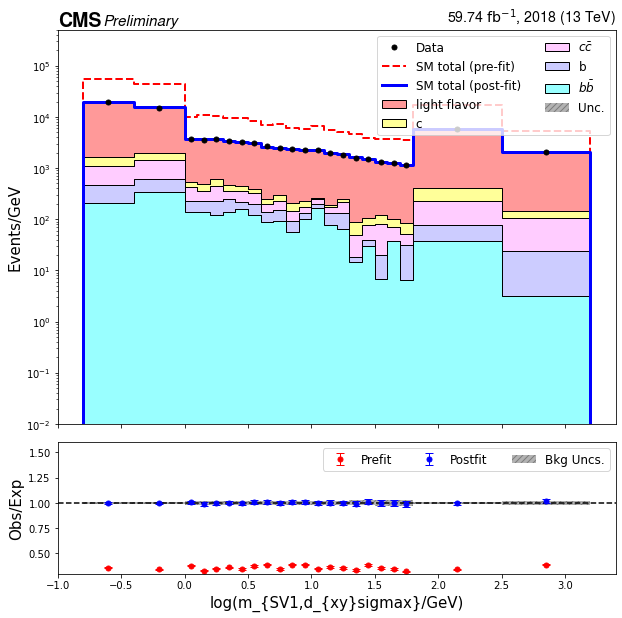

In [31]:
## year, category
year = '2018'
category = 'fail'
lumis = { #Values from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable                                                      
        '2016': "35.92",
        '2017': "41.53",
        '2018': "59.74"
    }
lumi=lumis[year]
saveplot = True
f = up.open("../hists/doublebsf.postfit")

plot_postfit(f, year, category, processes, saveplot)

In [72]:
from coffea import hist, processor 
from coffea.hist import plot
from coffea.util import load, save

year = '2017'

hists = load('../hists/doublebsf'+year+'.scaled')

gentype_map = {
    'bb':       0,
    'b':        1,
    'cc' :      2,
    'c':        3,
    'other':    4
}

category_map = {
        "pass": 1,
        "fail": 0
        }
bkg_hists = hists['bkg']
signal_hists = hists['sig']

In [92]:
###
# N-1 of the fat jet tagger unstack plot
###
#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
    
from cycler import cycler
from collections import defaultdict, OrderedDict

bkg_hists_ZHbbvsQCD=hist.Hist(
                'Events',
                hist.Cat("process", "Process"),
                hist.Bin('ZHbbvsQCD','ZHbbvsQCD',15,0,1)
            )
values=bkg_hists['ZHbbvsQCD'].integrate('process','QCD').rebin('gentype',hist.Bin('gentype', 'Gen Type', [0,1])).sum('gentype').values()[()][2:]
print(values)
bkg_hists_ZHbbvsQCD.fill(process='bb',ZHbbvsQCD=values.sum())
#bkg_hists_ZHbbvsQCD.rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD',13,))
signal_hists_ZHbbvsQCD=signal_hists['ZHbbvsQCD'].integrate('gentype')
print(signal_hists_ZHbbvsQCD.axis("ZHbbvsQCD").edges())
signal_hists_ZHbbvsQCD.rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD', [0.2,0.26666667,0.33333333,0.4,0.46666667,0.53333333,0.6,0.66666667,0.73333333,0.8,0.86666667,0.93333333,1.]))
print(signal_hists_ZHbbvsQCD.values())
process = hist.Cat("process", "Process", sorting="placement")
cats = ("process",)

sig_map = OrderedDict()
sig_map['Mz1000_mhs70_Mdm150'] = ("Mz1000_mhs70_Mdm150*",)
#bkg_map["Hbb"] = ("Hbb*",)
#bkg_map["V+jets"] = (["DY+HF","W+HF","Z+HF"],)
#bkg_map["VV"] = (["WW", "WZ", "ZZ"],)
#bkg_map["Top"] = (["ST","TT"],)
#bkg_map["QCD"] = ("QCD*",)
#bkg_map["bb"] = (,)

signal_hists_ZHbbvsQCD = signal_hists_ZHbbvsQCD.group(cats, process, sig_map)
        
plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
colors = ['#cccccc','#0000ff','#000000','#ff0000','#3cb371','#FFA500']


fig, ax = plt.subplots(figsize=(13,11), sharex=True)
ax.set_prop_cycle(cycler(color=colors))

line_opts = {'linestyle':'dashdot', 'linewidth':3}
line_opts2 = {'linestyle':'-'}
error_opts = {'linewidth': 0}

#plot.plot1d(bkg_hists_ZHbbvsQCD,
#                overlay="process",
#                ax=ax,
##                clear=False,
#                density=True,
#                line_opts=line_opts2,
#                )

plot.plot1d(signal_hists_ZHbbvsQCD,
                overlay="process",
                ax=ax,
                clear=False,
                density=True,
                line_opts=line_opts,
                )

ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
args = {'linestyle':'--', 'linewidth': 5}
ax.autoscale(axis='x', tight=True)
#ax.set_yscale('log')
#ax.set_ylim(.1, None)
leg = ax.legend(ncol=2, loc='best')

coffee = plt.text(0., 1., u"☕ "+'Signal Region', fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
lumitext = plt.text(1., 1., lumi+r" fb$^{-1}$ (13 TeV)", fontsize=17, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

#os.system('mkdir -p ../plots/darkhiggs/prefit/'+year+'/')
#plot_path = os.path.abspath('../plots/darkhiggs/prefit/'+year+'/') 
#plot_name = 'unstack_sr_ZHbbvsQCD.png'
#fig.savefig(os.path.join(plot_path, plot_name))




[  285.62450798   433.70445746   520.43443633   827.86142143
  1154.57912396  1115.10935944  1562.45678102  1963.22859842
  2339.53935762  3867.39588401  6066.07691049 13943.13240333
 48967.63541058]
[0.         0.06666667 0.13333333 0.2        0.26666667 0.33333333
 0.4        0.46666667 0.53333333 0.6        0.66666667 0.73333333
 0.8        0.86666667 0.93333333 1.        ]


ValueError: Axis <Bin (name=ZHbbvsQCD) instance at 0x2b4ff7b51fd0> has no interval that fully contains identifier <Interval ([0.266666666667, 0.333333333333)) instance at 0x2b4ff7b5deb8>